In [27]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from scipy.stats import mannwhitneyu

In [28]:
df = pd.read_csv('source/FReDA4.csv')

In [29]:
df["Group1"].value_counts()

Group1
SubGroup1    3842
SubGroup3    3402
SubGroup7    2856
SubGroup2    2084
SubGroup8     382
SubGroup9     368
SubGroup4     292
SubGroup5     284
SubGroup6      90
Name: count, dtype: int64

In [30]:
df["Group2"].value_counts()

Group2
One-sided Deprivation     4940
Couple Satisfaction       3842
Couple Deprivation        3402
One-sided Saturation       666
Couple Dissatisfaction     660
Couple Saturation           90
Name: count, dtype: int64

In [31]:
df["Group3"].value_counts()

Group3
Couple Deprivation     8342
Couple Satisfaction    3842
Couple Saturation       756
Couple Mixed            660
Name: count, dtype: int64

In [32]:
def collapse_kde_into_bins(kde_df, bins=[0, 1, 2, 3, 4, 5, 6]):
    df = kde_df.copy()
    N = df["N_total"].iloc[0]

    dx = df["x"].diff().median()

    df["bin"] = pd.cut(df["x"], bins=bins, labels=range(len(bins) - 1), right=False)

    out = (
        df.groupby("bin")
        .apply(lambda g: pd.Series({
            "density_sum": (g["density"] * dx).sum(),
        }))
        .reset_index()
    )
    return out

In [33]:
satisfied = df[df["Group3"] == "Couple Satisfaction"].copy()

In [34]:
mixed = df[df["Group3"] == "Couple Mixed"].copy()

In [35]:
deprived = df[df["Group3"] == "Couple Deprivation"].copy()

In [36]:
saturated = df[df["Group3"] == "Couple Saturation"].copy()

In [37]:
deprived_one =  df[df["Group2"] == "One-sided Deprivation"].copy()
deprived_both = df[df["Group1"] == "SubGroup3"].copy()
deprived_me = df[df["Group1"] == "SubGroup2"].copy()
deprived_partner = df[df["Group1"] == "SubGroup7"].copy()

In [38]:
saturated_one =  df[df["Group2"] == "One-sided Saturation"].copy()
saturated_both = df[df["Group1"] == "SubGroup6"].copy()
saturated_me = df[df["Group1"] == "SubGroup5"].copy()
saturated_partner = df[df["Group1"] == "SubGroup8"].copy()

In [39]:
dfs = [
    satisfied,
    deprived,
    saturated,
    mixed,
    deprived_one,
    deprived_both,
    # deprived_me,
    # deprived_partner,
    saturated_one,
    saturated_both,
    # saturated_me,
    # saturated_partner,
]

for df2 in dfs:
    mask = (
        df2.groupby('CoupleId')['Frequency']
        .nunique()
        .eq(1)
    )
    df2['TouchMatch'] = df2['CoupleId'].map(
        lambda cid: 'Alignment' if mask.get(cid, False) else 'Disalignment'
    )

    diffs = (
        df2.groupby("CoupleId")["Frequency"]
        .apply(lambda x: abs(np.diff(sorted(x)))[0])
    )
    df2["TouchDiff"] = df2["CoupleId"].map(diffs)
    df2["Diff"] = df2["TouchDiff"].apply(
        lambda d: "Alignment" if d == 0 else ("+1" if d < 1 else ("+3 or more" if d >= 3 else f"+{int(d)}"))
    )

In [40]:
ref_size = len(dfs[0])

weights = []
for df in dfs:
    w = np.ones(len(df)) * (len(df)/ref_size)
    weights.append(w)
all_weights = np.concatenate(weights)


In [41]:
bw = 1.15
new_palette = [
    "#C4A000",
    "#355C9C",
    "#B76A8D",
    "#009688",
]

labels = [
    "Whole",
    "0 difference",
    "1 or more",
    "2 or more",
    "Touch Desire"
]


ft_size = 18
tt_size = 24
x_title = 0.01
y_title = 0.89

In [42]:
print(satisfied.shape[0])

3842


In [43]:
group_sizes = {
    "Satisfied": satisfied.shape[0],
    "Deprived": deprived.shape[0],
    "Saturated": saturated.shape[0],
    "Mixed": mixed.shape[0]
}

ref_group = "Deprived"
ref_size = group_sizes[ref_group]

y_limits = {}

alpha = 0.25   # softness parameter (try 0.4–0.6)

for group, size in group_sizes.items():
    scale = (ref_size / size) ** alpha
    height = 1 * scale          # base height = 1
    y_limits[group] = [-height/2, height/2]

y_limits["Deprived"] = [-0.52, 0.52]
print(y_limits)

{'Satisfied': [-0.6069434243001581, 0.6069434243001581], 'Deprived': [-0.52, 0.52], 'Saturated': [-0.9112910433906981, 0.9112910433906981], 'Mixed': [-0.9427609097714843, 0.9427609097714843]}


In [44]:
shade = [0.25, 0.50, 0.75, 0.95]
shade.reverse()
inside = ["quartile", None, None, None]

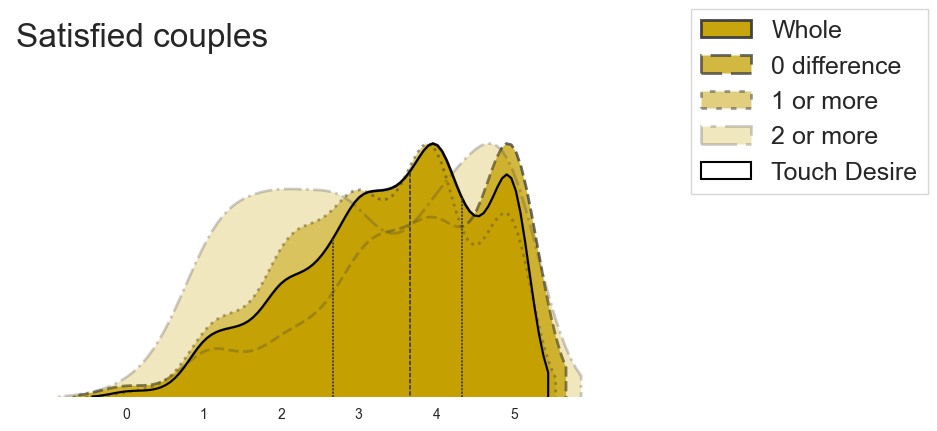

In [45]:
data = satisfied
color = new_palette[0]
conditions = {
    "all": data[data['TouchDiff'] >= 0],
    "0": data[data['TouchDiff'] == 0],
    "1 or more": data[data['TouchDiff'] >= 1],
    "2 or more": data[data['TouchDiff'] >= 2],
}
fig, ax = plt.subplots(figsize=(8, 5))

for i, (label, subset) in enumerate(conditions.items()):
    n_before = len(ax.collections)

    ax = sns.violinplot(
        data=subset,
        x='Frequency',
        color=color,
        label=label,
        alpha=shade[i],
        inner=inside[i],
        dodge=False,
        saturation=1,
    )
    new_violins = ax.collections[n_before:]

    for violin in new_violins:
        if i == 0:
            violin.set_linestyle("-")
            violin.set_linewidth(2)
        elif i == 1:
            violin.set_linestyle("--")
            violin.set_linewidth(2)
        elif i == 2:
            violin.set_linestyle(":")
            violin.set_linewidth(2)
        elif i == 3:
            violin.set_linestyle("-.")
            violin.set_linewidth(2)

# EXCLUDE quartile lines from legend
for line in ax.lines:
    line.set_label("_nolegend_")

plt.grid(False)

sns.violinplot(data=data,
               x="Desire",
               fill=False,
               color="k",
               inner=None,
               )

x_legend = plt.legend(
    labels=labels,
    loc='upper right',
    bbox_to_anchor=(1.5, 1.04),
    fontsize=ft_size,
    fancybox=False
)

l = plt.ylabel('')
n = plt.xlabel('')

current_xlim = ax.get_xlim()
ax.set_xlim(left=-1.5, right=6.5)
ax.set_xticks([0, 1, 2, 3, 4, 5])

sns.despine(top=True, right=True, left=True, bottom=True)

y_limits["Satisfied"][0] = 0
ax.set_ylim(y_limits["Satisfied"])
t = plt.title("Satisfied couples", fontsize=tt_size, y=y_title, x=x_title, ha='left')
plt.savefig('output/img/kde/satisfied_couples3.png', dpi=600, transparent=False, bbox_inches='tight')

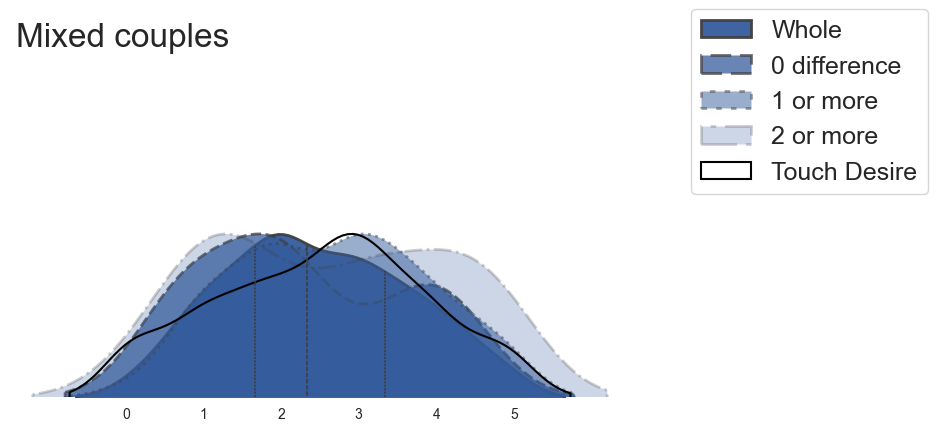

In [46]:
data = mixed
color = new_palette[1]

conditions = {
    "all": data[data['TouchDiff'] >= 0],
    "0": data[data['TouchDiff'] == 0],
    "1 or more": data[data['TouchDiff'] >= 1],
    "2 or more": data[data['TouchDiff'] >= 2],
}
fig, ax = plt.subplots(figsize=(8, 5))

for i, (label, subset) in enumerate(conditions.items()):
    n_before = len(ax.collections)

    ax = sns.violinplot(
        data=subset,
        x='Frequency',
        color=color,
        # fill=True,
        label=label,
        alpha=shade[i],
        inner=inside[i],
        dodge=False,
        saturation=1,
        # cut = 0
    )
    new_violins = ax.collections[n_before:]

    for violin in new_violins:
        if i == 0:
            violin.set_linestyle("-")
            violin.set_linewidth(2)
        elif i == 1:
            violin.set_linestyle("--")
            violin.set_linewidth(2)
        elif i == 2:
            violin.set_linestyle(":")
            violin.set_linewidth(2)
        elif i == 3:
            violin.set_linestyle("-.")
            violin.set_linewidth(2)

# EXCLUDE quartile lines from legend
for line in ax.lines:
    line.set_label("_nolegend_")

plt.grid(False)

sns.violinplot(data=data,
               x="Desire",
               fill=False,
               color="k",
               inner=None,
               )

x_legend = plt.legend(
    labels=labels,
    loc='upper right',
    bbox_to_anchor=(1.5, 1.04),
    fontsize=ft_size
)

l = plt.ylabel('')
n = plt.xlabel('')

current_xlim = ax.get_xlim()
ax.set_xlim(left=-1.5, right=6.5)
ax.set_xticks([0, 1, 2, 3, 4, 5])

sns.despine(top=True, right=True, left=True, bottom=True)

y_limits["Mixed"][0] = 0
ax.set_ylim(y_limits["Mixed"])

t = plt.title("Mixed couples", fontsize=tt_size, y=y_title, x=x_title, ha='left')
plt.savefig('output/img/kde/mixed_couples3.png', dpi=600, transparent=False, bbox_inches='tight')

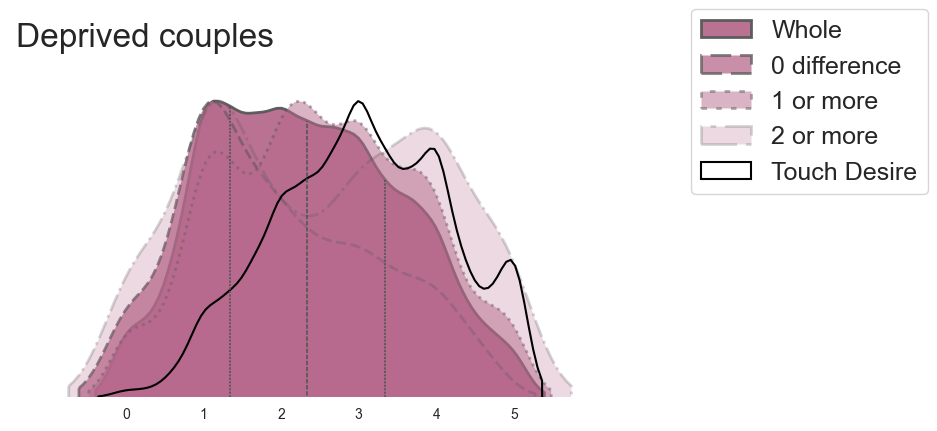

In [47]:
data = deprived
color = new_palette[2]

conditions = {
    "all": data[data['TouchDiff'] >= 0],
    "0": data[data['TouchDiff'] == 0],
    "1 or more": data[data['TouchDiff'] >= 1],
    "2 or more": data[data['TouchDiff'] >= 2],
}
fig, ax = plt.subplots(figsize=(8, 5))

for i, (label, subset) in enumerate(conditions.items()):
    n_before = len(ax.collections)

    ax = sns.violinplot(
        data=subset,
        x='Frequency',
        color=color,
        label=label,
        alpha=shade[i],
        inner=inside[i],
        dodge=False,
        saturation=1,
    )
    new_violins = ax.collections[n_before:]

    for violin in new_violins:
        if i == 0:
            violin.set_linestyle("-")
            violin.set_linewidth(2)
        elif i == 1:
            violin.set_linestyle("--")
            violin.set_linewidth(2)
        elif i == 2:
            violin.set_linestyle(":")
            violin.set_linewidth(2)
        elif i == 3:
            violin.set_linestyle("-.")
            violin.set_linewidth(2)

# EXCLUDE quartile lines from legend
for line in ax.lines:
    line.set_label("_nolegend_")

plt.grid(False)

sns.violinplot(data=data,
               x="Desire",
               fill=False,
               color="k",
               inner=None,
               )

x_legend = plt.legend(
    labels=labels,
    loc='upper right',
    bbox_to_anchor=(1.5, 1.04),
    fontsize=ft_size
)

l = plt.ylabel('')
n = plt.xlabel('')

current_xlim = ax.get_xlim()
ax.set_xlim(left=-1.5, right=6.5)
ax.set_xticks([0, 1, 2, 3, 4, 5])

sns.despine(top=True, right=True, left=True, bottom=True)

y_limits["Deprived"][0] = 0
ax.set_ylim(y_limits["Deprived"])

t = plt.title("Deprived couples", fontsize=tt_size, y=y_title, x=x_title, ha='left')
plt.savefig('output/img/kde/deprived_couples3.png', dpi=600, transparent=False, bbox_inches='tight')

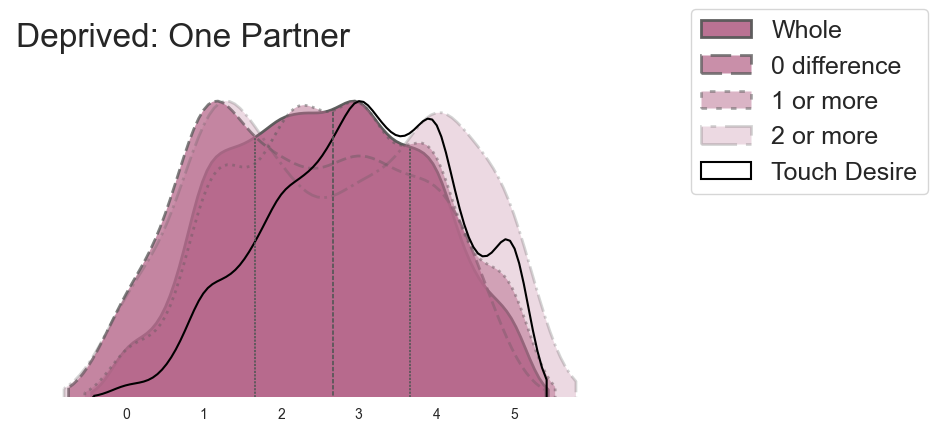

In [48]:
data = deprived_one
color = new_palette[2]

conditions = {
    "all": data[data['TouchDiff'] >= 0],
    "0": data[data['TouchDiff'] == 0],
    "1 or more": data[data['TouchDiff'] >= 1],
    "2 or more": data[data['TouchDiff'] >= 2],
}
fig, ax = plt.subplots(figsize=(8, 5))

for i, (label, subset) in enumerate(conditions.items()):
    n_before = len(ax.collections)

    ax = sns.violinplot(
        data=subset,
        x='Frequency',
        color=color,
        label=label,
        alpha=shade[i],
        inner=inside[i],
        dodge=False,
        saturation=1,
    )
    new_violins = ax.collections[n_before:]

    for violin in new_violins:
        if i == 0:
            violin.set_linestyle("-")
            violin.set_linewidth(2)
        elif i == 1:
            violin.set_linestyle("--")
            violin.set_linewidth(2)
        elif i == 2:
            violin.set_linestyle(":")
            violin.set_linewidth(2)
        elif i == 3:
            violin.set_linestyle("-.")
            violin.set_linewidth(2)

# EXCLUDE quartile lines from legend
for line in ax.lines:
    line.set_label("_nolegend_")

plt.grid(False)

sns.violinplot(data=data,
               x="Desire",
               fill=False,
               color="k",
               inner=None,
               )

x_legend = plt.legend(
    labels=labels,
    loc='upper right',
    bbox_to_anchor=(1.5, 1.04),
    fontsize=ft_size
)

l = plt.ylabel('')
n = plt.xlabel('')

current_xlim = ax.get_xlim()
ax.set_xlim(left=-1.5, right=6.5)
ax.set_xticks([0, 1, 2, 3, 4, 5])

sns.despine(top=True, right=True, left=True, bottom=True)

y_limits["Deprived"][0] = 0
ax.set_ylim(y_limits["Deprived"])

t = plt.title("Deprived: One Partner", fontsize=tt_size, y=y_title, x=x_title, ha='left')
plt.savefig('output/img/kde/deprived_one3.png', dpi=600, transparent=False, bbox_inches='tight')

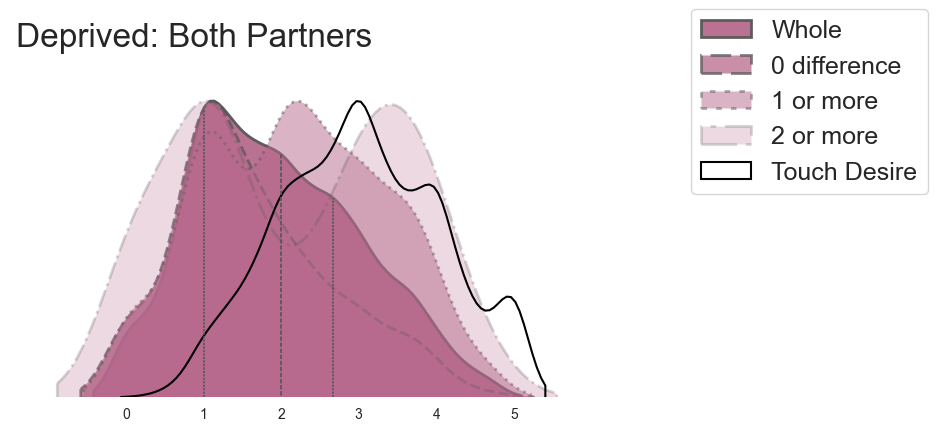

In [49]:
data = deprived_both
color = new_palette[2]

conditions = {
    "all": data[data['TouchDiff'] >= 0],
    "0": data[data['TouchDiff'] == 0],
    "1 or more": data[data['TouchDiff'] >= 1],
    "2 or more": data[data['TouchDiff'] >= 2],
}
fig, ax = plt.subplots(figsize=(8, 5))

for i, (label, subset) in enumerate(conditions.items()):
    n_before = len(ax.collections)

    ax = sns.violinplot(
        data=subset,
        x='Frequency',
        color=color,
        label=label,
        alpha=shade[i],
        inner=inside[i],
        dodge=False,
        saturation=1,
    )
    new_violins = ax.collections[n_before:]

    for violin in new_violins:
        if i == 0:
            violin.set_linestyle("-")
            violin.set_linewidth(2)
        elif i == 1:
            violin.set_linestyle("--")
            violin.set_linewidth(2)
        elif i == 2:
            violin.set_linestyle(":")
            violin.set_linewidth(2)
        elif i == 3:
            violin.set_linestyle("-.")
            violin.set_linewidth(2)

# EXCLUDE quartile lines from legend
for line in ax.lines:
    line.set_label("_nolegend_")

plt.grid(False)

sns.violinplot(data=data,
               x="Desire",
               fill=False,
               color="k",
               inner=None,
               )

x_legend = plt.legend(
    labels=labels,
    loc='upper right',
    bbox_to_anchor=(1.5, 1.04),
    fontsize=ft_size
)

l = plt.ylabel('')
n = plt.xlabel('')

current_xlim = ax.get_xlim()
ax.set_xlim(left=-1.5, right=6.5)
ax.set_xticks([0, 1, 2, 3, 4, 5])

sns.despine(top=True, right=True, left=True, bottom=True)

y_limits["Deprived"][0] = 0
ax.set_ylim(y_limits["Deprived"])

t = plt.title("Deprived: Both Partners", fontsize=tt_size, y=y_title, x=x_title, ha='left')
plt.savefig('output/img/kde/deprived_both3.png', dpi=600, transparent=False, bbox_inches='tight')

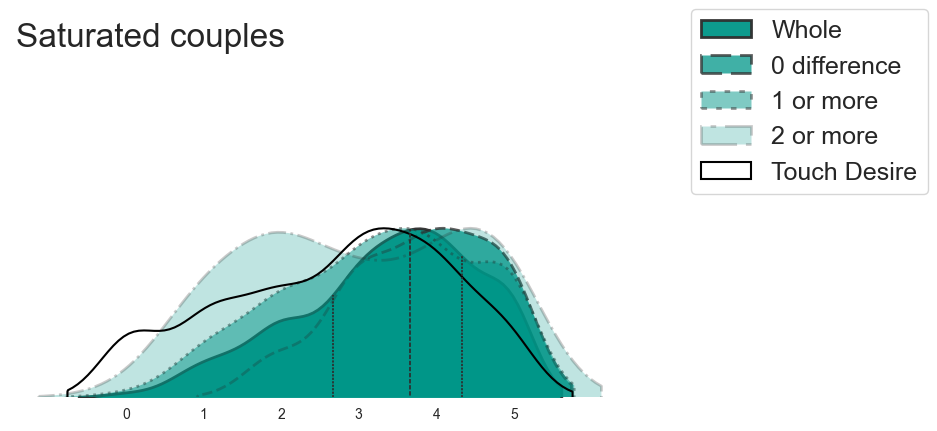

In [50]:
data = saturated
color = new_palette[3]

conditions = {
    "all": data[data['TouchDiff'] >= 0],
    "0": data[data['TouchDiff'] == 0],
    "1 or more": data[data['TouchDiff'] >= 1],
    "2 or more": data[data['TouchDiff'] >= 2],
}

fig, ax = plt.subplots(figsize=(8, 5))

for i, (label, subset) in enumerate(conditions.items()):
    n_before = len(ax.collections)

    ax = sns.violinplot(
        data=subset,
        x='Frequency',
        color=color,
        # fill=True,
        label=label,
        alpha=shade[i],
        inner=inside[i],
        dodge=False,
        saturation=1,
        # cut = 0
    )
    new_violins = ax.collections[n_before:]

    for violin in new_violins:
        if i == 0:
            violin.set_linestyle("-")
            violin.set_linewidth(2)
        elif i == 1:
            violin.set_linestyle("--")
            violin.set_linewidth(2)
        elif i == 2:
            violin.set_linestyle(":")
            violin.set_linewidth(2)
        elif i == 3:
            violin.set_linestyle("-.")
            violin.set_linewidth(2)

# EXCLUDE quartile lines from legend
for line in ax.lines:
    line.set_label("_nolegend_")

plt.grid(False)

sns.violinplot(data=data,
               x="Desire",
               fill=False,
               color="k",
               inner=None,
               )

x_legend = plt.legend(
    labels=labels,
    loc='upper right',
    bbox_to_anchor=(1.5, 1.04),
    fontsize=ft_size
)

l = plt.ylabel('')
n = plt.xlabel('')

current_xlim = ax.get_xlim()
ax.set_xlim(left=-1.5, right=6.5)
ax.set_xticks([0, 1, 2, 3, 4, 5])

sns.despine(top=True, right=True, left=True, bottom=True)

y_limits["Saturated"][0] = 0
ax.set_ylim(y_limits["Saturated"])

t = plt.title("Saturated couples", fontsize=tt_size, y=y_title, x=x_title, ha='left')
plt.savefig('output/img/kde/saturated_couples3.png', dpi=600, transparent=False, bbox_inches='tight')

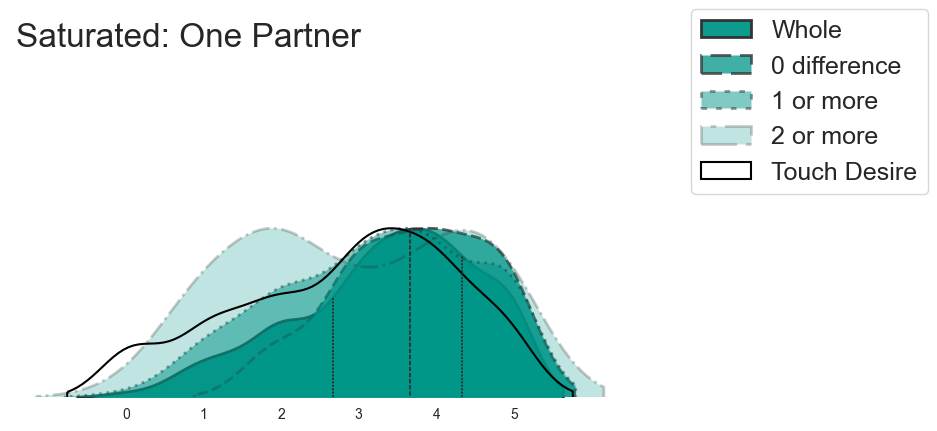

In [51]:
data = saturated_one
color = new_palette[3]

conditions = {
    "all": data[data['TouchDiff'] >= 0],
    "0": data[data['TouchDiff'] == 0],
    "1 or more": data[data['TouchDiff'] >= 1],
    "2 or more": data[data['TouchDiff'] >= 2],
}

fig, ax = plt.subplots(figsize=(8, 5))

for i, (label, subset) in enumerate(conditions.items()):
    n_before = len(ax.collections)

    ax = sns.violinplot(
        data=subset,
        x='Frequency',
        color=color,
        # fill=True,
        label=label,
        alpha=shade[i],
        inner=inside[i],
        dodge=False,
        saturation=1,
        # cut = 0
    )
    new_violins = ax.collections[n_before:]

    for violin in new_violins:
        if i == 0:
            violin.set_linestyle("-")
            violin.set_linewidth(2)
        elif i == 1:
            violin.set_linestyle("--")
            violin.set_linewidth(2)
        elif i == 2:
            violin.set_linestyle(":")
            violin.set_linewidth(2)
        elif i == 3:
            violin.set_linestyle("-.")
            violin.set_linewidth(2)

# EXCLUDE quartile lines from legend
for line in ax.lines:
    line.set_label("_nolegend_")

plt.grid(False)

sns.violinplot(data=data,
               x="Desire",
               fill=False,
               color="k",
               inner=None,
               )

x_legend = plt.legend(
    labels=labels,
    loc='upper right',
    bbox_to_anchor=(1.5, 1.04),
    fontsize=ft_size
)

l = plt.ylabel('')
n = plt.xlabel('')

current_xlim = ax.get_xlim()
ax.set_xlim(left=-1.5, right=6.5)
ax.set_xticks([0, 1, 2, 3, 4, 5])

sns.despine(top=True, right=True, left=True, bottom=True)

y_limits["Saturated"][0] = 0
ax.set_ylim(y_limits["Saturated"])

t = plt.title("Saturated: One Partner", fontsize=tt_size, y=y_title, x=x_title, ha='left')
plt.savefig('output/img/kde/saturated_one3.png', dpi=600, transparent=False, bbox_inches='tight')

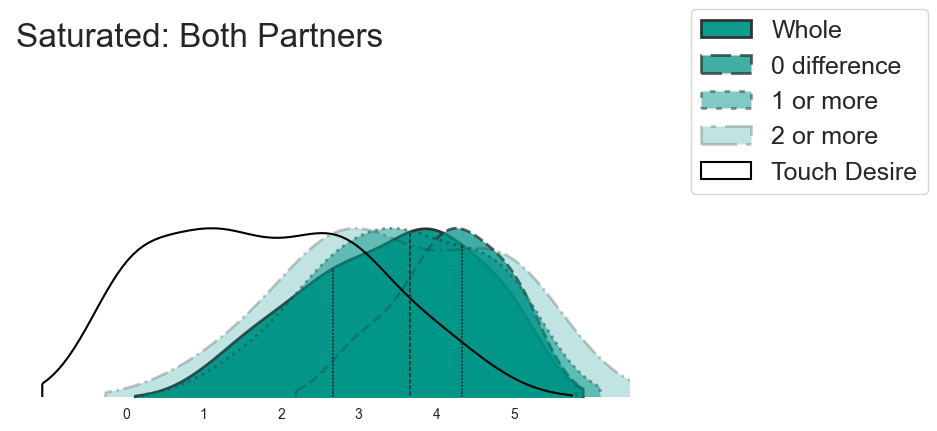

In [52]:
data = saturated_both
color = new_palette[3]

conditions = {
    "all": data[data['TouchDiff'] >= 0],
    "0": data[data['TouchDiff'] == 0],
    "1 or more": data[data['TouchDiff'] >= 1],
    "2 or more": data[data['TouchDiff'] >= 2],
}

fig, ax = plt.subplots(figsize=(8, 5))

for i, (label, subset) in enumerate(conditions.items()):
    n_before = len(ax.collections)

    ax = sns.violinplot(
        data=subset,
        x='Frequency',
        color=color,
        # fill=True,
        label=label,
        alpha=shade[i],
        inner=inside[i],
        dodge=False,
        saturation=1,
        # cut = 0
    )
    new_violins = ax.collections[n_before:]

    for violin in new_violins:
        if i == 0:
            violin.set_linestyle("-")
            violin.set_linewidth(2)
        elif i == 1:
            violin.set_linestyle("--")
            violin.set_linewidth(2)
        elif i == 2:
            violin.set_linestyle(":")
            violin.set_linewidth(2)
        elif i == 3:
            violin.set_linestyle("-.")
            violin.set_linewidth(2)

# EXCLUDE quartile lines from legend
for line in ax.lines:
    line.set_label("_nolegend_")

plt.grid(False)

sns.violinplot(data=data,
               x="Desire",
               fill=False,
               color="k",
               inner=None,
               )

x_legend = plt.legend(
    labels=labels,
    loc='upper right',
    bbox_to_anchor=(1.5, 1.04),
    fontsize=ft_size
)

l = plt.ylabel('')
n = plt.xlabel('')

current_xlim = ax.get_xlim()
ax.set_xlim(left=-1.5, right=6.5)
ax.set_xticks([0, 1, 2, 3, 4, 5])

sns.despine(top=True, right=True, left=True, bottom=True)

y_limits["Saturated"][0] = 0
ax.set_ylim(y_limits["Saturated"])

t = plt.title("Saturated: Both Partners", fontsize=tt_size, y=y_title, x=x_title, ha='left')
plt.savefig('output/img/kde/saturated_both3.png', dpi=600, transparent=False, bbox_inches='tight')